## **Overview :-**
This project uses **DistilBERT**, a smaller, faster, and lighter version of BERT, for detecting emotions from text. The model is fine-tuned on a text dataset and deployed as an interactive web application using **Streamlit**.


## **Dataset :-** https://huggingface.co/datasets/dair-ai/emotion

## **Importing Libraries**

In [ ]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
import torch

In [ ]:
import pandas as pd
from datasets import load_dataset

ds = load_dataset("dair-ai/emotion", "split")

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
ds.set_format(type='pandas')

## **Training Data**

In [ ]:
df = ds['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
ds['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
ds['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [ ]:
classes = ds['train'].features['label'].names
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [ ]:
df['label_name'] = df['label'].apply(lambda x: classes[x])

In [ ]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## **Validation and Test Data**

In [ ]:
df_valid = ds['validation'][:]
df_valid.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,0
1,i feel like i am still looking at a blank canv...,0
2,i feel like a faithful servant,2
3,i am just feeling cranky and blue,3
4,i can have for a treat or if i am feeling festive,1


In [ ]:
df_valid.shape

(2000, 2)

In [ ]:
df_test = ds['test'][:]
df_test.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,0
1,im updating my blog because i feel shitty,0
2,i never make her separate from me because i do...,0
3,i left with my bouquet of red and yellow tulip...,1
4,i was feeling a little vain when i did this one,0


In [ ]:
df_test.shape

(2000, 2)

## **Dataset Analysis**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [ ]:
df['label_name'].value_counts(ascending = True)

,count
label_name,
surprise,572
love,1304
fear,1937
anger,2159
sadness,4666
joy,5362


In [ ]:
df['label_name'].value_counts(ascending = True)/len(df)*100

,count
label_name,
surprise,3.57500
love,8.15000
fear,12.10625
anger,13.49375
sadness,29.16250
joy,33.51250


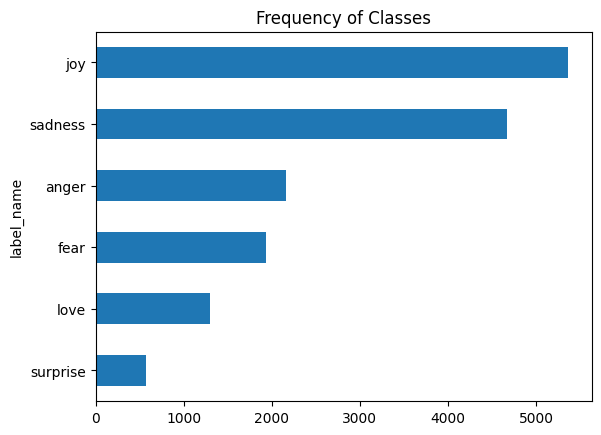

In [ ]:
import matplotlib.pyplot as plt

label_counts = df['label_name'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title('Frequency of Classes')
plt.show()

In [ ]:
df['Words Per Tweet'] = df['text'].str.split().apply(len)

In [ ]:
df.head()

,text,label,label_name,Words Per Tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


In [ ]:
df['Words Per Tweet'].max()

66

<Axes: title={'center': 'Words Per Tweet'}, xlabel='label_name'>

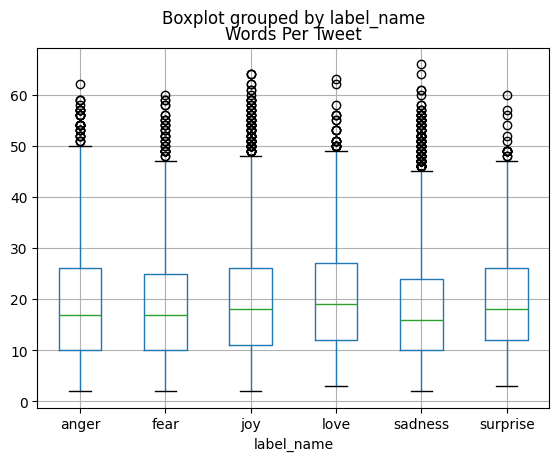

In [ ]:
df.boxplot("Words Per Tweet", by='label_name')

## **Text to Tokens Conversion**

In [ ]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
tokenizer.vocab_size, tokenizer.model_max_length

(30522, 512)

## **Tokenization of the Emotion Data**

In [ ]:
ds.reset_format()

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
def tokenize(batch):
  temp =tokenizer(batch['text'], padding=True, truncation=True)
  return temp

print(tokenize(ds["train"][:5]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2572, 2412, 3110, 16839, 9080, 12863, 2055, 1996, 13788, 1045, 2097, 2113, 2008, 2009, 2003, 2145, 2006, 1996, 3200, 102, 0], [101, 1045, 2572, 3110, 24665, 7140, 11714, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [ ]:
emotions_encoded = ds.map(tokenize, batched=True, batch_size=None)

In [ ]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [ ]:
# Get the max length of tokenized inputs from the emotions_encoded dataset
max_length_train = max([len(item['input_ids']) for item in emotions_encoded['train']])
max_length_validation = max([len(item['input_ids']) for item in emotions_encoded['validation']])
max_length_test = max([len(item['input_ids']) for item in emotions_encoded['test']])

In [ ]:
max_length_train , max_length_validation , max_length_test

(87, 69, 66)

## **Model Building**

In [ ]:
model_ckpt

'distilbert-base-uncased'

In [ ]:
from transformers import AutoModel
import torch

model = AutoModel.from_pretrained(model_ckpt)

In [ ]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

## **Fine-Tuning DistilBERT**

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = len(classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device

device(type='cuda')

In [ ]:
from transformers import TrainingArguments

In [ ]:
batch_size = 64
model_name = "distilbert-finetuned-emotion"

training_args = TrainingArguments(output_dir = model_name,
                                 #run_name="my-emotion-finetuning-run", # Add this line
                                 num_train_epochs=2,
                                 learning_rate = 2e-5,
                                 per_device_train_batch_size= batch_size,
                                 per_device_eval_batch_size = batch_size,
                                 weight_decay=0.01,
                                 #evaluation_strategy = "epoch",
                                 disable_tqdm=False)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer)

<ipython-input-43-731d64f15024>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


In [ ]:
!pip install wandb -qU
import wandb
wandb.login()
# Before calling trainer.train()
wandb.init(project="my-emotion-finetuning-run", name="distilbert-finetuned-emotion")

# Now call the train method
trainer.train()

In [ ]:
preds_outputs = trainer.predict(emotions_encoded['test'])
preds_outputs.metrics

{'test_loss': 0.18073706328868866,
 'test_accuracy': 0.9225,
 'test_f1': 0.9225237858027057,
 'test_runtime': 3.6653,
 'test_samples_per_second': 545.66,
 'test_steps_per_second': 8.731}

## **Saving the Model**

In [ ]:
trainer.save_model("./distilbert-finetuned-emotion-saved")

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the fine-tuned model and tokenizer
model_path = "./distilbert-finetuned-emotion-saved"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Save the model and tokenizer with reduced precision (e.g., fp16)
# This significantly reduces the model size.
model.save_pretrained(model_path, max_shard_size="100MB", safe_serialization=True)
tokenizer.save_pretrained(model_path)

('./distilbert-finetuned-emotion-saved/tokenizer_config.json',
 './distilbert-finetuned-emotion-saved/special_tokens_map.json',
 './distilbert-finetuned-emotion-saved/vocab.txt',
 './distilbert-finetuned-emotion-saved/added_tokens.json',
 './distilbert-finetuned-emotion-saved/tokenizer.json')

## **Loading the Model**

In [ ]:
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_path)
loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)

print(loaded_model)

## **Classification Report**

In [ ]:
import numpy as np
y_preds = np.argmax(preds_outputs.predictions, axis=1)
y_true = emotions_encoded['test'][:]['label']

In [ ]:
from sklearn.metrics import classification_report
print(classes)
print(classification_report(y_true, y_preds))

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       581
           1       0.95      0.93      0.94       695
           2       0.78      0.87      0.82       159
           3       0.93      0.92      0.92       275
           4       0.87      0.93      0.90       224
           5       0.81      0.65      0.72        66

    accuracy                           0.92      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.92      0.92      0.92      2000



In [ ]:
label_counts

,count
label_name,
surprise,572
love,1304
fear,1937
anger,2159
sadness,4666
joy,5362


## **Prediction on Single Text**

In [ ]:
device

device(type='cuda')

In [ ]:
text = 'i want to kill you'
input_encoded = tokenizer(text, return_tensors='pt')
# Move the input tensor to the same device as the model
input_encoded = input_encoded.to('cpu')
with torch.no_grad():
  outputs = model(**input_encoded)

logits = outputs.logits
pred = torch.argmax(logits, dim=1).item()
pred, classes[pred]

(3, 'anger')

In [ ]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-0.1415, -0.5371, -2.2430,  3.0944,  0.3670, -2.2816]]), hidden_states=None, attentions=None)